In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Keras Transformer.ipynb (출처?) 에서 발췌
query = tf.keras.layers.Input(shape=(None,3,))
value = tf.keras.layers.Input(shape=(4,2,)) 
key = tf.keras.layers.Input(shape=(4,3,))

x = tf.keras.layers.Attention()([query, value, key])
model = tf.keras.models.Model(inputs=[query, value, key], outputs=x)
model.summary()

temp_k = tf.constant([[[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]]], dtype=tf.float32)  # (4, 2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4, 2)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4, 3)]       0           []                               
                                                                                                  
 attention (Attention)          (None, None, 2)      0           ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

In [2]:
temp_q = tf.constant([[[0, 10, 0]]], dtype=tf.float32)  # (1, 3)
model.predict([temp_q,temp_v,temp_k])

1/1 [==============================] - 0s 250ms/step


array([[[10.,  0.]]], dtype=float32)

In [ ]:
temp_q = tf.constant([[[0, 0, 10]]], dtype=tf.float32)  # (1, 3)
model.predict([temp_q,temp_v,temp_k]) # 중복된 item이 있는데 softmax를 사용하기 때문에 평균값으로 계산됨

1/1 [==============================] - 0s 124ms/step


array([[[550. ,   5.5]]], dtype=float32)

In [7]:
temp_q = tf.constant([[[10, 10, 0]]], dtype=tf.float32)  # (1, 3)
model.predict([temp_q,temp_v,temp_k])

1/1 [==============================] - 0s 18ms/step


array([[[5.5, 0. ]]], dtype=float32)

In [12]:
# by definition

def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

temp_q = tf.constant([[[10, 10, 0]]], dtype=tf.float32)  # (1, 3)
att = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(att)

tf.Tensor([[[5.500000e+00 4.638301e-25]]], shape=(1, 1, 2), dtype=float32)


In [13]:
# https://yjam.tistory.com/72
# https://github.com/philipperemy/keras-attention-mechanism

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

input_dims = 32
batch_size = 10000

def get_data(n, input_dims, attention_column=1):
    train_x = np.random.standard_normal(size=(batch_size, input_dims))
    train_y = np.random.randint(low=0, high=2, size=(n, 1))
    train_x[:, attention_column] = train_y[:, 0] # train data를 만들 때 어떤 field 가 중요한지 골라야하기 때문에 정답지를 특징의 한 field에 넣음(attention_column)
    
    return (train_x, train_y)

def build_model(input_dims):
    # Input Layer
    input_layer     = tf.keras.layers.Input(shape=(input_dims,))
    
    # Attention Layer
    attention_probs  = tf.keras.layers.Dense(input_dims, activation='softmax')(input_layer)
    attention_mul    = tf.keras.layers.multiply([input_layer, attention_probs])

    # Full Connected Layer
    fc_attention_mul = tf.keras.layers.Dense(64)(attention_mul)
    y                = tf.keras.layers.Dense(1, activation='sigmoid')(fc_attention_mul)

    return tf.keras.Model(inputs=[input_layer], outputs=y)
   
model = build_model(input_dims)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           1056        ['input_4[0][0]']                
                                                                                                  
 multiply (Multiply)            (None, 32)           0           ['input_4[0][0]',                
                                                                  'dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 64)           2112        ['multiply[0][0]']         

In [14]:
train_x, train_y = get_data(10000, 32, 5)
test_x,  test_y  = get_data(10000, 32, 5)
 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=20, batch_size=64, validation_split=0.5, verbose=2)

Epoch 1/20
79/79 - 1s - loss: 0.6836 - accuracy: 0.6054 - val_loss: 0.6716 - val_accuracy: 0.6766 - 1s/epoch - 17ms/step
Epoch 2/20
79/79 - 0s - loss: 0.6376 - accuracy: 0.7528 - val_loss: 0.5970 - val_accuracy: 0.7644 - 272ms/epoch - 3ms/step
Epoch 3/20
79/79 - 0s - loss: 0.5340 - accuracy: 0.7864 - val_loss: 0.4852 - val_accuracy: 0.8074 - 292ms/epoch - 4ms/step
Epoch 4/20
79/79 - 0s - loss: 0.4196 - accuracy: 0.8300 - val_loss: 0.3753 - val_accuracy: 0.8536 - 256ms/epoch - 3ms/step
Epoch 5/20
79/79 - 0s - loss: 0.3041 - accuracy: 0.8910 - val_loss: 0.2590 - val_accuracy: 0.9134 - 290ms/epoch - 4ms/step
Epoch 6/20
79/79 - 0s - loss: 0.1880 - accuracy: 0.9468 - val_loss: 0.1460 - val_accuracy: 0.9678 - 250ms/epoch - 3ms/step
Epoch 7/20
79/79 - 0s - loss: 0.0913 - accuracy: 0.9862 - val_loss: 0.0635 - val_accuracy: 0.9926 - 300ms/epoch - 4ms/step
Epoch 8/20
79/79 - 0s - loss: 0.0359 - accuracy: 0.9980 - val_loss: 0.0255 - val_accuracy: 0.9984 - 300ms/epoch - 4ms/step
Epoch 9/20
79/79 -

In [15]:
layer_outputs    = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
output_data      = activation_model.predict(test_x)

print(len(output_data))

313/313 [==============================] - 1s 2ms/step
5


In [16]:
print(output_data[1], output_data[1].shape)


[[0.02098739 0.01111601 0.02790913 ... 0.01310225 0.08088455 0.03020792]
 [0.0158598  0.02546464 0.02507741 ... 0.02350556 0.00849889 0.01369895]
 [0.02785118 0.04279878 0.03320111 ... 0.04175897 0.01272146 0.02673574]
 ...
 [0.01326774 0.02060122 0.02080379 ... 0.01775255 0.10038956 0.0312004 ]
 [0.01587052 0.01895125 0.01421478 ... 0.01366026 0.02852399 0.01559421]
 [0.0152818  0.02836916 0.02635371 ... 0.02378076 0.0283107  0.03043086]] (10000, 32)


In [17]:
attention_vector = np.mean(output_data[1], axis=0)
print(attention_vector, attention_vector.shape)

[0.02230046 0.02240891 0.01969562 0.02140514 0.02730497 0.3039727
 0.02108144 0.02586034 0.02464957 0.02259491 0.02688062 0.01765197
 0.0195353  0.0229398  0.01850786 0.02249076 0.02716797 0.02162039
 0.02189265 0.02211913 0.02068168 0.02181168 0.02735232 0.02912251
 0.02041456 0.01757251 0.01884936 0.02205979 0.01902228 0.02069891
 0.02381011 0.02652499] (32,)


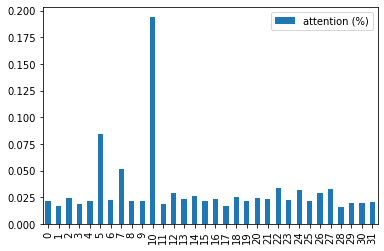

In [ ]:
df = pd.DataFrame(attention_vector.transpose(), columns=['attention (%)'])
df.plot.bar()